In [1]:
import pandas as pd 
from sqlalchemy import create_engine 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  
import numpy as np
import matplotlib.pyplot as plt 
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from tensorflow.keras.regularizers import l2 
from sklearn.cluster import KMeans
from tensorflow.keras.utils import to_categorical

2024-06-07 11:38:55.840299: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 11:38:55.840346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 11:38:55.841371: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-07 11:38:55.848026: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 11:38:56.804970: W tensorflow/compiler/tf2

In [2]:
# Loading data from database
def load_data_from_db(engine, table_name):
    query = f"SELECT * FROM data_lake.{table_name};"
    df = pd.read_sql(query, engine)
    return df

# Connect to database
db_params = {
    'host': '194.171.191.226',
    'port': '6379',
    'database': 'postgres',
    'user': 'group20',
    'password': 'blockd_2024group20_28'
}

db_url = f"postgresql://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['database']}"
engine = create_engine(db_url)


### First iteration

In [3]:
# Load data
incident_table = "safe_driving"
df = load_data_from_db(engine, incident_table)

# Only 'is_valid'
df = df[df['is_valid'] == True]

# Clean 'category' from spaces 
df['category'] = df['category'].str.strip()

# Filter speeding incidents
speeding_df = df[df['category'] == 'SPEED'].copy()

# Severity number from 'incident_severity'
speeding_df['severity'] = speeding_df['incident_severity'].str.extract(r'(\d+)').astype(int)

# Speeding incidents 
print("Number of speeding incidents:", len(speeding_df))

# Enough samples for splitting
if len(speeding_df) < 2:
    raise ValueError("Not enough samples to split into training and testing sets.")

Number of speeding incidents: 386791


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 64)            1600      
                                                                 
 batch_normalization (Batch  (None, 18, 64)            256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 18, 64)            0         
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 64)                73792     
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

2024-06-07 11:39:34.858109: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-06-07 11:39:34.858977: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1468 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:c1:00.0, compute capability: 8.6


Epoch 1/30


2024-06-07 11:39:37.854336: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-06-07 11:39:37.944197: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-07 11:39:38.966104: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-07 11:39:40.122981: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5c3daf2800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-07 11:39:40.123033: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-06-07 11:39:40.130926: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1717760380.294530  208181 device_compiler.h:186] 

1058/1058 [==============================] - 15s 8ms/step - loss: 0.8380 - mae: 0.4139 - val_loss: 0.1842 - val_mae: 0.1209 - lr: 0.0010
Epoch 2/30
1058/1058 [==============================] - 6s 5ms/step - loss: 0.1451 - mae: 0.1865 - val_loss: 0.1050 - val_mae: 0.1409 - lr: 0.0010
Epoch 3/30
1058/1058 [==============================] - 6s 6ms/step - loss: 0.1047 - mae: 0.1600 - val_loss: 0.0982 - val_mae: 0.1252 - lr: 0.0010
Epoch 4/30
1058/1058 [==============================] - 5s 5ms/step - loss: 0.0957 - mae: 0.1539 - val_loss: 0.0945 - val_mae: 0.1445 - lr: 0.0010
Epoch 5/30
1058/1058 [==============================] - 6s 6ms/step - loss: 0.0942 - mae: 0.1552 - val_loss: 0.0944 - val_mae: 0.1431 - lr: 0.0010
Epoch 6/30
1058/1058 [==============================] - 6s 6ms/step - loss: 0.0940 - mae: 0.1554 - val_loss: 0.0942 - val_mae: 0.1563 - lr: 0.0010
Epoch 7/30
1058/1058 [==============================] - 6s 6ms/step - loss: 0.0940 - mae: 0.1557 - val_loss: 0.0946 - val_mae: 0

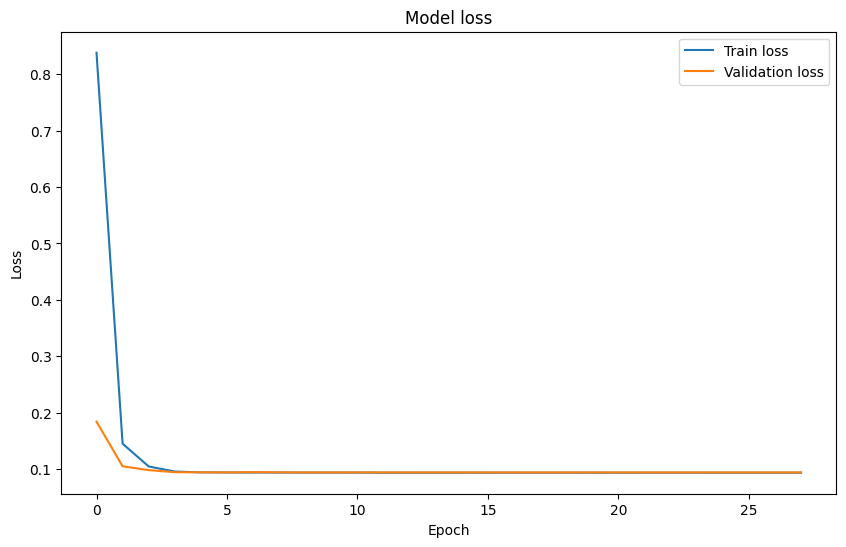

In [4]:
# Feature Engineering
speeding_df['event_start'] = pd.to_datetime(speeding_df['event_start'])
speeding_df['hour'] = speeding_df['event_start'].dt.hour
speeding_df['day_of_week'] = speeding_df['event_start'].dt.dayofweek
speeding_df['month'] = speeding_df['event_start'].dt.month

# Select features and target
features = ['latitude', 'longitude', 'speed_kmh', 'end_speed_kmh', 'maxwaarde', 'hour', 'day_of_week', 'month']
target = 'severity'

X = speeding_df[features]
y = speeding_df[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define sequence length
sequence_length = 20

# Create sequences
def create_sequences(data, target, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        targets.append(target[i + sequence_length])
    return np.array(sequences), np.array(targets)

X_sequences, y_sequences = create_sequences(X_scaled, y.values, sequence_length)

# Splitting data
X_train_full, X_test, y_train_full, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.125, random_state=42) 
# Defining the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, len(features)), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile 
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary 
model.summary()

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train
history = model.fit(X_train, y_train, epochs=30, batch_size=256, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

# Preprocess data for zones
zone_table = "safe_driving" 
zone_data = load_data_from_db(engine, zone_table)

# Only 'is_valid'
zone_data = zone_data[zone_data['is_valid'] == True]

# Clean the 'category' from spaces 
zone_data['category'] = zone_data['category'].str.strip()

# Preprocess data for zones
zone_data['event_start'] = pd.to_datetime(zone_data['event_start'])
zone_data['hour'] = zone_data['event_start'].dt.hour
zone_data['day_of_week'] = zone_data['event_start'].dt.dayofweek
zone_data['month'] = zone_data['event_start'].dt.month
# Select features for zones
zone_features = ['latitude', 'longitude', 'speed_kmh', 'end_speed_kmh', 'maxwaarde', 'hour', 'day_of_week', 'month']

# Scale features
X_zone = zone_data[zone_features]
X_zone_scaled = scaler.transform(X_zone)

# Create sequences if needed
X_zone_sequences, _ = create_sequences(X_zone_scaled, np.zeros(len(X_zone)), sequence_length)  # Assuming the target is not used during prediction

# Make predictions for zones
severity_predictions = model.predict(X_zone_sequences)

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Second iteration

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 8, 64)             1600      
                                                                 
 batch_normalization_2 (Bat  (None, 8, 64)             256       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 8, 64)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 6, 64)             12352     
                                                                 
 batch_normalization_3 (Bat  (None, 6, 64)             256       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 6, 64)            

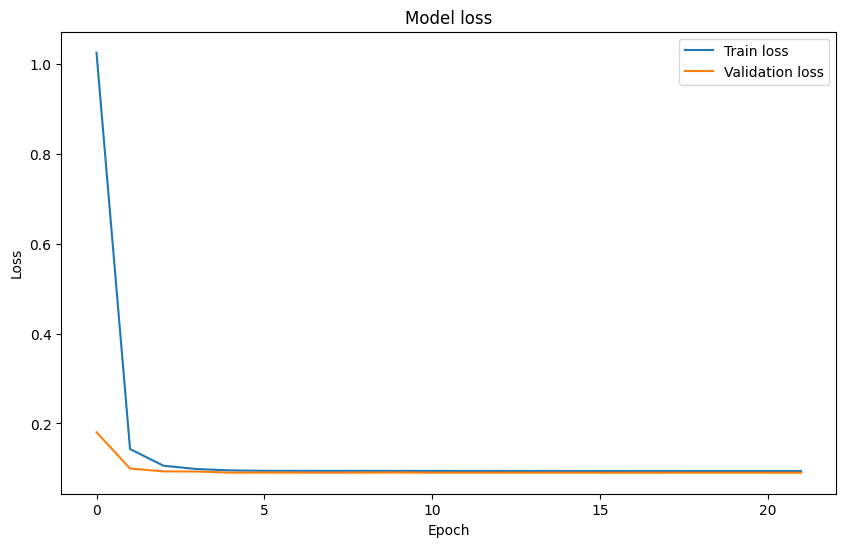

In [5]:
# Feature Engineering
speeding_df['event_start'] = pd.to_datetime(speeding_df['event_start'])
speeding_df['hour'] = speeding_df['event_start'].dt.hour
speeding_df['day_of_week'] = speeding_df['event_start'].dt.dayofweek
speeding_df['month'] = speeding_df['event_start'].dt.month

# Select features and target
features = ['latitude', 'longitude', 'speed_kmh', 'end_speed_kmh', 'maxwaarde', 'hour', 'day_of_week', 'month']
target = 'severity'

X = speeding_df[features]
y = speeding_df[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define sequence length
sequence_length = 10

# Create sequences
def create_sequences(data, target, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        targets.append(target[i + sequence_length])
    return np.array(sequences), np.array(targets)

X_sequences, y_sequences = create_sequences(X_scaled, y.values, sequence_length)

# Splitting data
X_train_full, X_test, y_train_full, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.125, random_state=42) 
# Defining the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, len(features)), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile 
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary 
model.summary()

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train
history = model.fit(X_train, y_train, epochs=30, batch_size=256, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

# Preprocess data for zones
zone_table = "safe_driving" 
zone_data = load_data_from_db(engine, zone_table)

# Only 'is_valid'
zone_data = zone_data[zone_data['is_valid'] == True]

# Clean the 'category' from spaces 
zone_data['category'] = zone_data['category'].str.strip()

# Preprocess data for zones
zone_data['event_start'] = pd.to_datetime(zone_data['event_start'])
zone_data['hour'] = zone_data['event_start'].dt.hour
zone_data['day_of_week'] = zone_data['event_start'].dt.dayofweek
zone_data['month'] = zone_data['event_start'].dt.month
# Select features for zones
zone_features = ['latitude', 'longitude', 'speed_kmh', 'end_speed_kmh', 'maxwaarde', 'hour', 'day_of_week', 'month']

# Scale features
X_zone = zone_data[zone_features]
X_zone_scaled = scaler.transform(X_zone)

# Create sequences if needed
X_zone_sequences, _ = create_sequences(X_zone_scaled, np.zeros(len(X_zone)), sequence_length)  # Assuming the target is not used during prediction

# Make predictions for zones
severity_predictions = model.predict(X_zone_sequences)

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()